Last year the Rarey and BioSolveIT groups published [a paper](https://doi.org/10.1007/s10822-024-00581-1) describing LOBSTER, a data set of small molecule overlays drawn from the PDB. The carefully curated and constructed data set is intended to be a new benchmarking set for testing molecular alignment (superposition) tools. I'm really happy to have an up-to-date replacement for the older ["AZ set"](https://doi.org/10.1021/ci400020a), which is what I've previously always used when looking at alignment.
The well-written paper (as one expects from the Rarey group!) is definitely worth reading in order to understand the decisions made in the curation workflow.
The code used for the curation is available in GitHub and the data set itself can be downloaded from Zenodo. There are links in the (open access) paper to both places.

I have a number of ideas for experiments to do using the LOBSTER set, so I wanted to get it loaded up into a database I could use for those experiments. This blog post demonstrates how I did that.

I'm using our [lwreg](https://pubs.acs.org/doi/full/10.1021/acs.jcim.4c01133) tool to handle registering the compound structures and to provide the basic schema for the database. You can `pip install` it from our [github repo](https://github.com/rinikerlab/lightweight-registration) I've blogged about [using lwreg together with the RDKit PostgreSQL cartridge](https://greglandrum.github.io/rdkit-blog/posts/2024-10-31-lwreg-and-the-cartridge.html) before.



In [33]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
%load_ext sql
%config SqlMagic.feedback=0


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Registering the structures and populating the data base

In [2]:
import lwreg
from lwreg import utils

At the command line I created the postgres database:
```
% createdb lobster_112024
```

In [3]:
config = utils.defaultConfig()
config

{'dbname': './testdb.sqlt',
 'dbtype': 'sqlite3',
 'standardization': 'fragment',
 'removeHs': 1,
 'useTautomerHashv2': 0,
 'registerConformers': 0,
 'numConformerDigits': 3,
 'lwregSchema': '',
 'cacheConnection': True}

Configure lwreg to work with the database I created. We'll turn off standardization and switch in to "registerConformers" mode.

In [4]:
config['dbtype'] = 'postgresql'
config['dbname'] = 'lobster_112024'
config['standardization'] = 'none'
config['registerConformers'] = 1
lwreg.set_default_config(config)

In [20]:
lwreg.initdb()

This will destroy any existing information in the registration database.
  are you sure? [yes/no]: yes


True

I downloaded the LOBSTER data from zenodo and extracted the zipfile locally.

Read in the SDFs containing the ligand structures and registering each 3D structure in lwreg:

In [21]:
import glob
sdfs = glob.glob('/scratch/Data/LOBSTER_112024/all_ligands/*.sdf')
registered = []
for sdf in sdfs:
    ms = [x for x in Chem.SDMolSupplier(sdf,removeHs=False) if x is not None]
    assert len(ms)==1
    m = ms[0]
    ligname = m.GetProp('_Name')
    ligpdb = m.GetProp('pdb_id')
    naomi_smis = m.GetProp('usmiles')
    mrn,confid = lwreg.register(mol=m)
    registered.append(((mrn,confid),ligname,ligpdb,naomi_smis,sdf))

Let's store the additional information from the LOBSTER data set in a separate table in the database:

In [60]:
cn = utils.connect(config=config) #< lwreg provides a convenience function to get a database connection
curs = cn.cursor()

curs.execute('create schema lobster_data')
curs.execute('''create table lobster_data.all_ligands
   (molregno integer references hashes, 
    conf_id integer references conformers,
    ligname text, pdb text, naomi_smiles text, filename text)''')
rows = [(x[0][0],x[0][1],x[1],x[2],x[3],x[4]) for x in registered]
curs.executemany('insert into lobster_data.all_ligands values (%s,%s,%s,%s,%s,%s)',rows)
cn.commit()

In [61]:
%sql postgresql://localhost/lobster_112024 \
    select count(*) from lobster_data.all_ligands;

1 rows affected.


count
3583


Install the RDKit catridge, load the molecules, and create an index on the molecule column so that we can do efficient substructure searching. More information about that in [this blog post](https://greglandrum.github.io/rdkit-blog/posts/2024-10-31-lwreg-and-the-cartridge.html)

In [110]:
%sql postgresql://localhost/lobster_112024 \
  create extension if not exists rdkit; \
    create schema if not exists rdk; \
    drop table if exists rdk.mols cascade;\
    select molregno,mol_from_ctab(molblock::cstring,false) m into rdk.mols from molblocks;\
    create index molidx on rdk.mols using gist(m);

[]

Let's add some fingerprints so that we can do similarity searches later. We'll add both bit- and count-based Morgan fingerprints with radius 3:

In [112]:
%sql postgresql://localhost/lobster_112024 \
    drop table if exists rdk.fps;\
  select molregno,morganbv_fp(m,3) as mfp3, morgan_fp(m,3) cfp3 into rdk.fps from rdk.mols;\
    create index fps_mfp3_idx on rdk.fps using gist(mfp3); \
    create index fps_cfp3_idx on rdk.fps using gist(cfp3);

[]

And now add some descriptors we might want to use:

In [114]:
%sql postgresql://localhost/lobster_112024 \
    drop table if exists rdk.descriptors;\
  select molregno,mol_numheavyatoms(m) nhvy, mol_amw(m) amw, mol_numrotatablebonds(m) nrot into rdk.descriptors from rdk.mols;


[]

Add a column with nTABS, a measure of molecular flexibility developed by Jessica Braun in our lab (Jessica is also the other author/developer of lwreg). 
There's [a paper](https://pubs.acs.org/doi/10.1021/acs.jcim.4c01513) and a [github repo](https://github.com/rinikerlab/TorsionAngularBinStrings) from which you can install the code.

In [120]:
import tabs
import tqdm
d = %sql postgresql://localhost/lobster_112024 \
  select molregno,molblock from molblocks

ntabs = []
for mrn,mb in tqdm.tqdm(d):
    m = Chem.MolFromMolBlock(mb,removeHs=False)
    nt = tabs.GetnTABS(m)
    ntabs.append((mrn,nt))  


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3218/3218 [00:13<00:00, 245.40it/s]


Add the nTABS values to the database:

In [123]:
cn = utils.connect(config=config)
curs = cn.cursor()

intabs = [(y,x) for x,y in ntabs]
curs.execute('alter table rdk.descriptors add column ntabs int')
curs.executemany('update rdk.descriptors set ntabs=%s where molregno=%s',intabs)
cn.commit()

Load data about pairs of aligned ligands from the LOBSTER data:

In [63]:
ind = [x.strip().split(';') for x in open('/scratch/Data/LOBSTER_112024/stats/pair_stats.csv','r')]
len(ind)

72593

In [64]:
ind.pop(0)

['query_file',
 'query',
 'pdb',
 'template_file',
 'template',
 'template_pdb',
 'ensemble',
 'morgan_fp_tanimoto',
 'gobbi_2D_pharmacophore_fp_tanimoto',
 'hac_difference',
 'shape_tversky_index',
 'shape_tanimoto_distance',
 'shape_protrude_distance',
 '']

And add that to the database too:

In [80]:
cn = utils.connect(config=config)
curs = cn.cursor()

curs.execute('''create table lobster_data.pair_stats
   (ligname1 text, pdb1 text, ligname2 text, pdb2 text, ensemble text,
    morgan_fp_tanimoto float, gobbi_2D_pharmacophore_fp_tanimoto float,
    hac_difference int, shape_tversky_index float, shape_tanimoto_distance float,
    shape_protrude_distance float)''')
rows = [(x[1],x[2],x[4],x[5],x[6],float(x[7]),float(x[8]),int(float(x[9])),float(x[10]),\
         float(x[11]),float(x[12]),) for x in ind]
curs.executemany('insert into lobster_data.pair_stats values (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)',rows)
cn.commit()

# Composition of the database

Now let's look at what we've got:

In [22]:
len(registered)

3583

Number of unique molregnos:

In [128]:
%sql postgresql://localhost/lobster_112024 \
  select count(*) from hashes

count
3218


Number of conformers (this is the number we registered):

In [129]:
%sql postgresql://localhost/lobster_112024 \
  select count(*) from conformers

count
3583


Number of pairs of aligned molecules:

In [125]:
%sql postgresql://localhost/lobster_112024 \
  select count(*) from lobster_data.pair_stats

count
72592


Number of unique naomi_smiles:

In [126]:
%sql postgresql://localhost/lobster_112024 \
  select count(distinct naomi_smiles) from lobster_data.all_ligands

count
3212


We'll look at the mismatch between the number of naomi_smiles and the number of molecule hashes below

# Retrieving info from the database

Get all of the molecule hashes for one particular molregno using lwreg functions:

In [32]:
lwreg.retrieve(id=12,as_hashes=True)

{12: {'fullhash': '6d22ca45dd6fb8f29d263532db4f913e7da47d6a',
  'formula': 'C18H16N6',
  'canonical_smiles': 'CN(c1cnc2nc(N)nc(N)c2c1)c1cccc2ccccc12',
  'no_stereo_smiles': 'CN(c1cnc2nc(N)nc(N)c2c1)c1cccc2ccccc12',
  'tautomer_hash': 'CN([C]1[CH][N][C]2[N][C]([N])[N][C]([N])[C]2[CH]1)[C]1[CH][CH][CH][C]2[CH][CH][CH][CH][C]21_4_0',
  'no_stereo_tautomer_hash': 'CN([C]1[CH][N][C]2[N][C]([N])[N][C]([N])[C]2[CH]1)[C]1[CH][CH][CH][C]2[CH][CH][CH][CH][C]21_4_0',
  'escape': '',
  'sgroup_data': '[]'}}

We can see here that the Hs have been removed by lwreg when calculating the hashes used for comparing 2D molecules to each other.

The molecules stored in the database still have their Hs. We can see this by retrieving the registered mol block for the molecule:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

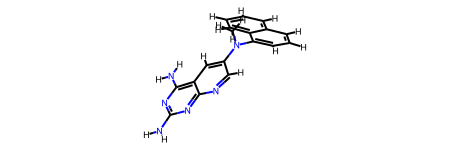

In [48]:
l = Chem.MolFromMolBlock(lwreg.retrieve(id=12)[12][0],removeHs=False)
l

Ligands that appear multiple times in the data set will have the same molregno but different confids. Let's find those:

In [40]:
from collections import defaultdict

repeated_ligands = defaultdict(list)

seen = set()
for tpl in registered:
    mrn,cid = tpl[0]
    if mrn in seen:
        repeated_ligands[mrn].append(cid)
    seen.add(mrn)
len(repeated_ligands)


219

Get the molregnos for the molecules that have more than two conformers present:

In [41]:
[k for k,v in repeated_ligands.items() if len(v)>2]

[84,
 180,
 110,
 77,
 68,
 92,
 78,
 503,
 583,
 53,
 384,
 568,
 296,
 565,
 281,
 228,
 715,
 1016,
 1335,
 1123,
 795,
 454,
 936,
 1029,
 1317,
 267,
 1601]

Each entry in the `repeated_ligands` dictionary includes the conf_ids of the conformers:

In [42]:
repeated_ligands[84]

[207, 215, 802, 968, 2150]

We can get the conformers themselves by calling `lwreg.retrieve()` with a list of (molregno,conf_id) tuples:

In [43]:
k = 84
confs = lwreg.retrieve(ids=[(k,x) for x in repeated_ligands[k]])

In [47]:
confs[(84,207)]

('AZM_E_303\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 19 19 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 S 9.311200 -40.854300 -76.602200 0\nM  V30 2 S 10.494600 -38.554800 -74.957200 0\nM  V30 3 O 9.730100 -37.268900 -74.826900 0\nM  V30 4 O 10.160500 -39.565300 -73.911800 0\nM  V30 5 O 8.149900 -43.309900 -77.530300 0\nM  V30 6 N 12.092600 -38.206500 -74.914100 0\nM  V30 7 N 10.151000 -38.844000 -77.734300 0\nM  V30 8 N 9.709100 -39.647400 -78.701300 0\nM  V30 9 N 8.662000 -41.847200 -79.186200 0\nM  V30 10 C 7.602600 -44.129200 -79.665200 0\nM  V30 11 C 10.029000 -39.323500 -76.470700 0\nM  V30 12 C 9.187000 -40.841600 -78.320400 0\nM  V30 13 C 8.151000 -43.081400 -78.698500 0\nM  V30 14 H 12.620400 -39.051600 -74.999600 0\nM  V30 15 H 12.320600 -37.593200 -75.670300 0\nM  V30 16 H 8.653100 -41.677800 -80.171700 0\nM  V30 17 H 7.673700 -43.787600 -80.602400 0\nM  V30 18 H 8.131400 -44.973300 -79.577000 0\nM  V30 19 H 6.643600 -44.3125

Convert all of those mol blocks into RDKit molecules:

In [50]:
conf_mols = [Chem.MolFromMolBlock(confs[x][0],removeHs=False) for x in confs]

And look at the first couple:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

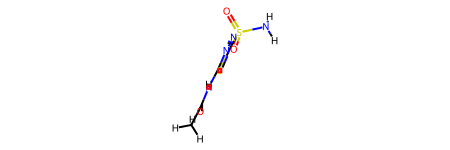

In [51]:
conf_mols[0]

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

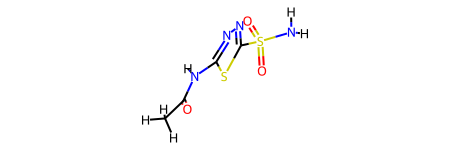

In [52]:
conf_mols[1]

Let's get all the pairs of conformers that have a shape Tversky score of between 0.8 and 0.9:

In [131]:
d = %sql select ligname1,pdb1,ligname2,pdb2 from lobster_data.pair_stats \
  where shape_tversky_index<=0.9 and shape_tversky_index>0.8;
d[:5]

 * postgresql://localhost/lobster_112024


[('03V_A_2002', '3u3k', 'NPO_A_300', '3u3r'),
 ('NPO_A_300', '3u3r', '03V_A_2002', '3u3k'),
 ('052_A_809', '4zeg', 'O23_A_901', '3wzk'),
 ('HS4_A_0', '3f17', 'KLG_A_0', '3rts'),
 ('NGH_A_306', '5lab', 'HS3_A_0', '3f16')]

In [132]:
accum = []
for ln1,pdb1,ln2,pdb2 in d[:10]:
    d1 = %sql postgresql://localhost/lobster_112024\
        select molregno,conf_id from lobster_data.all_ligands where \
      ligname=:ln1 and upper(pdb)=upper(:pdb1);
    d2 = %sql postgresql://localhost/lobster_112024\
        select molregno,conf_id from lobster_data.all_ligands where \
      ligname=:ln2 and upper(pdb)=upper(:pdb2);
    accum.append((tuple(d1[0]),tuple(d2[0])))

Look at a couple of pairs:

In [133]:
confs = lwreg.retrieve(ids=accum[0])
mols = [Chem.MolFromMolBlock(v[0],removeHs=False) for v in confs.values()]
IPythonConsole.drawMols3D(mols)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [134]:
confs = lwreg.retrieve(ids=accum[2])
mols = [Chem.MolFromMolBlock(v[0],removeHs=False) for v in confs.values()]
IPythonConsole.drawMols3D(mols)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Look at duplicate mismatches

According to lwreg we have 3218 unique structures, while the canonical SMILES provided with the Lobster data set (generated using the Hamburg group's Naomi package) says we have 3212. Let's look at the mismatches

In [138]:
%sql postgresql://localhost/lobster_112024 \
  select count(distinct molregno) from hashes join lobster_data.all_ligands using (molregno);

count
3218


In [140]:
%sql postgresql://localhost/lobster_112024 \
  select naomi_smiles,count(distinct molregno) cnt \
     from hashes join lobster_data.all_ligands using (molregno)\
    group by (naomi_smiles) order by cnt desc limit 10;

naomi_smiles,cnt
S=P(OP(=O)(OP(=O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](O)[C@@H]1O)O)O)(O)O,3
P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](O)[C@@H]1O)O,2
P1(=O)(O[C@@H]2[C@H](O[C@@H](N3C=4N=C(NC(=O)C4N=C3)N)[C@@H]2O)CO1)O,2
P(=O)(OP(=O)(O)O)(OCC(=O)N1[C@H](C(=O)O)CCC1)O,2
P(=O)(O)([C@@H](N)C)C[C@H](C(=O)N[C@H](C(=O)O)C)Cc1ccc(c2ccccc2)cc1,2
P1(=O)(O[C@@H]2[C@H](O[C@@H](N3C=4NC(=NC(=O)C4N=C3)N)[C@@H]2O)CO1)O,2
Brc1c2OC(=O)C(Br)=C(c2ccc1O)C,1
BrC=1C2=NC(=O)C(C=3Nc4c(cc(cc4)C(=O)O)C3NO)=C2C=CC1,1
Brc1c2c(OC(=O)C=C2CP(=O)(O)O)cc(c1)C,1
Brc1c(Br)c(Br)c2N(C(=Nc2c1Br)N(C)C)CC(=O)O,1


In [145]:
d = %sql postgresql://localhost/lobster_112024 \
  select molregno,canonical_smiles,naomi_smiles from \
      (select naomi_smiles,count(distinct molregno) cnt \
         from hashes join lobster_data.all_ligands using (molregno)\
         group by (naomi_smiles)) downsel join lobster_data.all_ligands using (naomi_smiles) \
          join hashes using (molregno)\
    where cnt>1 order by naomi_smiles asc;
d

molregno,canonical_smiles,naomi_smiles
927,Nc1nc2c(ncn2[C@@H]2O[C@@H]3CO[P@@](=O)(O)O[C@H]3[C@H]2O)c(=O)[nH]1,P1(=O)(O[C@@H]2[C@H](O[C@@H](N3C=4N=C(NC(=O)C4N=C3)N)[C@@H]2O)CO1)O
1363,Nc1nc2c(ncn2[C@@H]2O[C@@H]3CO[P@](=O)(O)O[C@H]3[C@H]2O)c(=O)[nH]1,P1(=O)(O[C@@H]2[C@H](O[C@@H](N3C=4N=C(NC(=O)C4N=C3)N)[C@@H]2O)CO1)O
1363,Nc1nc2c(ncn2[C@@H]2O[C@@H]3CO[P@](=O)(O)O[C@H]3[C@H]2O)c(=O)[nH]1,P1(=O)(O[C@@H]2[C@H](O[C@@H](N3C=4N=C(NC(=O)C4N=C3)N)[C@@H]2O)CO1)O
927,Nc1nc2c(ncn2[C@@H]2O[C@@H]3CO[P@@](=O)(O)O[C@H]3[C@H]2O)c(=O)[nH]1,P1(=O)(O[C@@H]2[C@H](O[C@@H](N3C=4N=C(NC(=O)C4N=C3)N)[C@@H]2O)CO1)O
2226,Nc1nc(=O)c2ncn([C@@H]3O[C@@H]4CO[P@](=O)(O)O[C@H]4[C@H]3O)c2[nH]1,P1(=O)(O[C@@H]2[C@H](O[C@@H](N3C=4NC(=NC(=O)C4N=C3)N)[C@@H]2O)CO1)O
91,Nc1nc(=O)c2ncn([C@@H]3O[C@@H]4CO[P@@](=O)(O)O[C@H]4[C@H]3O)c2[nH]1,P1(=O)(O[C@@H]2[C@H](O[C@@H](N3C=4NC(=NC(=O)C4N=C3)N)[C@@H]2O)CO1)O
2558,C[C@H](NC(=O)[C@H](Cc1ccc(-c2ccccc2)cc1)C[P@](=O)(O)[C@H](C)N)C(=O)O,P(=O)(O)([C@@H](N)C)C[C@H](C(=O)N[C@H](C(=O)O)C)Cc1ccc(c2ccccc2)cc1
82,C[C@H](NC(=O)[C@H](Cc1ccc(-c2ccccc2)cc1)C[P@@](=O)(O)[C@H](C)N)C(=O)O,P(=O)(O)([C@@H](N)C)C[C@H](C(=O)N[C@H](C(=O)O)C)Cc1ccc(c2ccccc2)cc1
627,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O,P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](O)[C@@H]1O)O
1957,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@@](=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O,P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](O)[C@@H]1O)O


These are all because the RDKit recognizes chiral phosphates and the Naomi SMILES seem not to.

Here are the first few molecules demonstrating this:

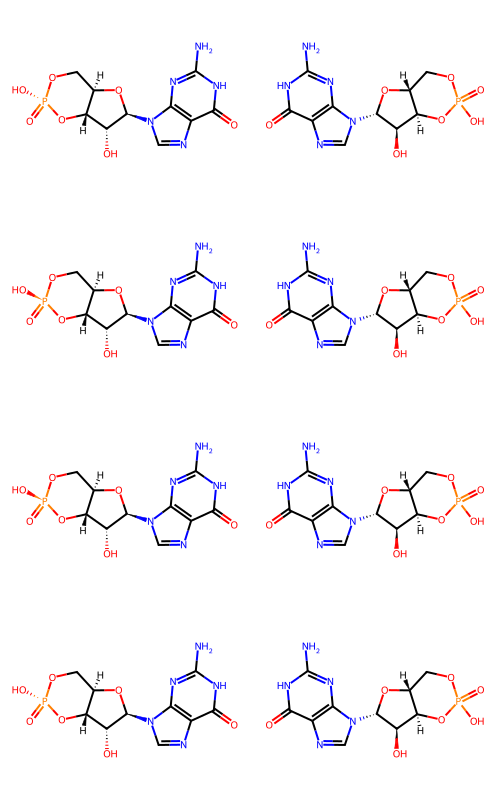

In [148]:
ms = []
for row in d:
    rm = Chem.MolFromSmiles(row[1])
    nm = Chem.MolFromSmiles(row[2])
    ms.extend((rm,nm))
Draw.MolsToGridImage(ms[:8],molsPerRow=2,subImgSize=(250,200))

I'm going to wrap this up here. I'll come back to the LOBSTER data set and this database again in future posts.